In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [ ]:
df = pd.read_csv('GoldPrice.csv')

In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.drop(['Vol.','Change %'], axis = 1, inplace = True)


In [ ]:
df

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
NumCols = df.columns.drop('Date')
df[NumCols] = df[NumCols].replace(',', '', regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [ ]:
df.head(10)

In [ ]:
df.duplicated().sum()

In [ ]:
df.isnull().sum()

In [ ]:
px.line(df, x='Date', y='Price', title='gold price data')

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price']])

In [ ]:
test_size = len(df) - int(0.8 * len(df))
train_size = len(df) - test_size

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [ ]:
# Build LSTM Model
input_layer = Input(shape=(seq_length, 1))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.2)(x)
# x = LSTM(64, return_sequences=True)(x)
# x = Dropout(0.2)(x)
# x = LSTM(64, return_sequences=True)(x)
# x = Dropout(0.2)(x)
# x = LSTM(64, return_sequences=True)(x)
# x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='nadam', loss='mse', metrics=['mse'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss[0]:.4f}')
print(f'Test MSE: {test_loss[1]:.4f}')

In [ ]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions to original price scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(y_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_unscaled, y_pred)
accuracy = (1 - mape) * 100

print(f'MAPE: {mape*100:.2f}%')
print(f'Accuracy: {accuracy:.2f}%')

In [ ]:
# Plot train and test split visualization
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'cyan'
plt.rc('axes', edgecolor='white')

plt.plot(df['Date'][:train_size], df['Price'][:train_size], color='black', lw=2)
plt.plot(df['Date'][train_size:], df['Price'][train_size:], color='red', lw=2)

plt.title('gold price train and test', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['train set', 'test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

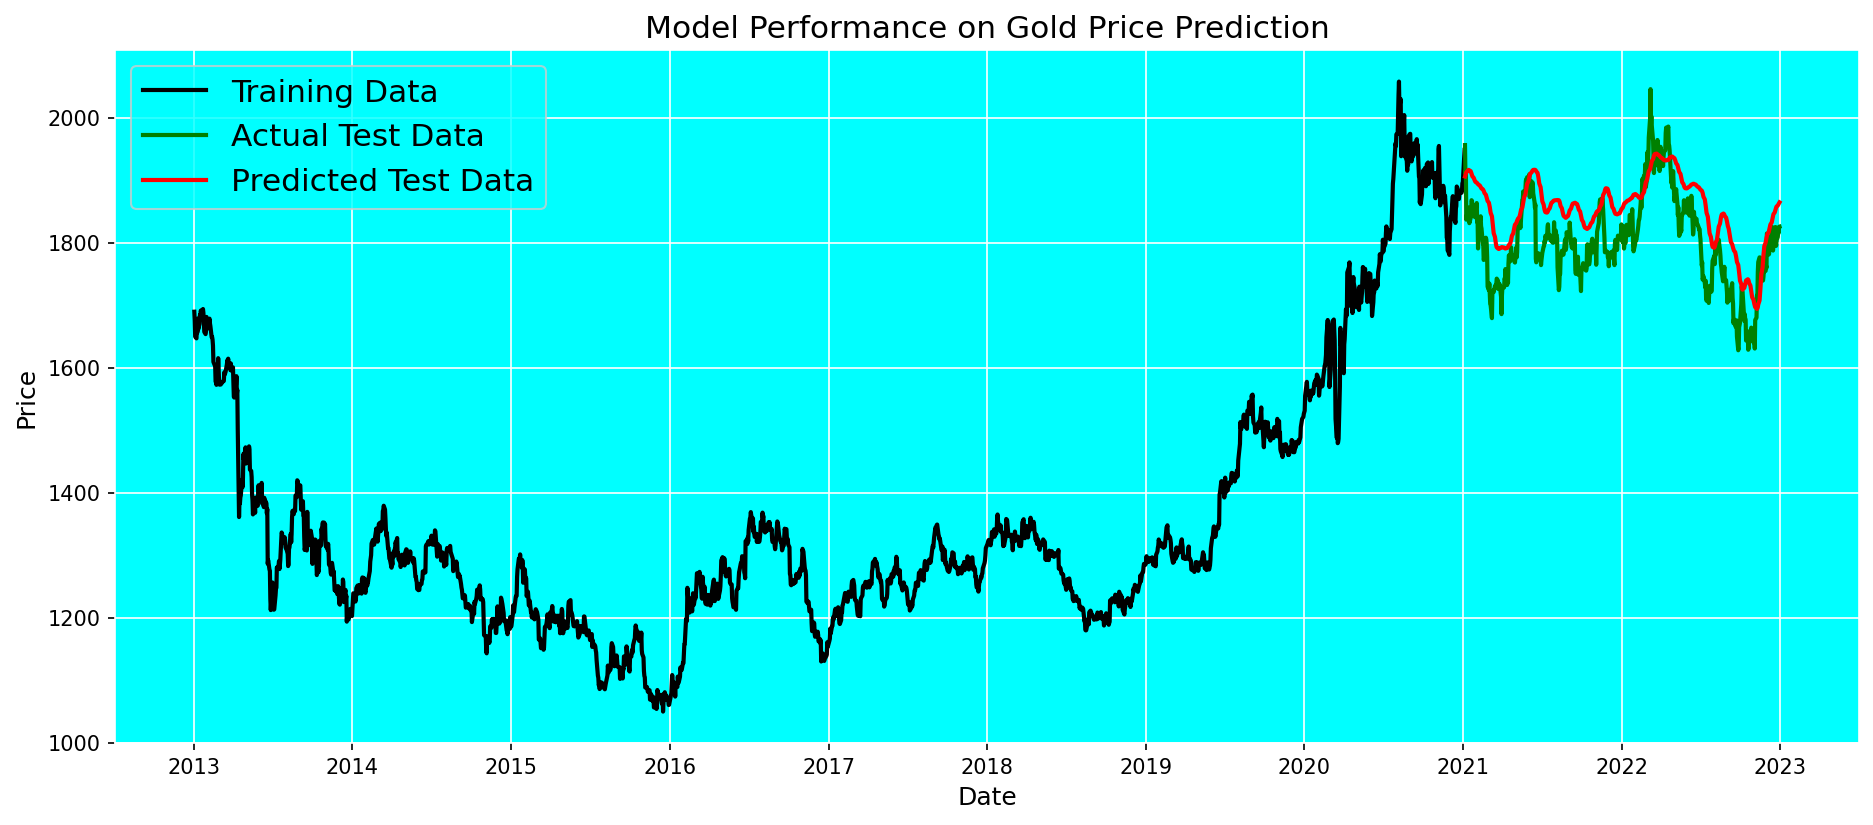


Model Performance Metrics:
MAPE: 3.24%
Accuracy: 96.76%

Prediction Samples:
Predicted Price Range: $1694.41 - $1943.06
Actual Price Range: $1628.20 - $2046.30


In [69]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'cyan'
plt.rc('axes', edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
y_test_true = y_test_unscaled
y_test_pred = y_pred
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color = 'green', lw = 2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color = 'red', lw = 2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

print(f'\nModel Performance Metrics:')
print(f'MAPE: {mape*100:.2f}%')
print(f'Accuracy: {accuracy:.2f}%')
print(f'\nPrediction Samples:')
print(f'Predicted Price Range: ${y_pred.min():.2f} - ${y_pred.max():.2f}')
print(f'Actual Price Range: ${y_test_unscaled.min():.2f} - ${y_test_unscaled.max():.2f}')